## DATA 620 Spring 2019
#### Week 9 Project 3

2019-04-01

## Assignment

__This is a Team Project!__  For this project, please work with the entire class as one collaborative group!  Your project should be submitted (as an Jupyter Notebook via GitHub). You should all submit a link to the same repository. 

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect? 

Source: Natural Language Processing with Python, exercise 6.10.2.

### Import packages

In [1]:
import nltk
from nltk.corpus import names
from nltk.classify import apply_features
import random
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
from sklearn.utils import shuffle
import re
import itertools

# hide warnings after first occurence
# warnings.filterwarnings(action='once')


### Data import


In [2]:
# check whether nltk data is available if not download
try:
    nltk.data.find('corpora/names/README')
except LookupError:
    nltk.download('names')

# import data
dfNames = \
pd.concat(
    [pd.DataFrame({'name' : names.words('female.txt')
                  , 'gender' : 'female'})
    , pd.DataFrame({'name' : names.words('male.txt')
                    , 'gender' : 'male'})],axis=0,ignore_index=True)

# make all names lowercase
dfNames['name'] = dfNames['name'].str.lower()

# create features of interest and store in new column
dfNames['firstChar'] = dfNames['name'].str[0]
dfNames['firstBi'] = dfNames['name'].str[:2]
dfNames['firstTri'] = dfNames['name'].str[:3]
dfNames['lastChar'] = dfNames['name'].str[-1]
dfNames['lastBi'] = dfNames['name'].str[-2:]
dfNames['lastTri'] = dfNames['name'].str[-3:]
dfNames['cntChar'] = dfNames['name'].str.len()
dfNames['cntUnqChar'] = dfNames['name'].apply(set).apply(len)
dfNames['cntConsns'] = dfNames['name'].str.count(r'[bcdfghjklmnpqrstvwxzy]', flags=re.I)
dfNames['cntVowels'] = dfNames['name'].str.count(r'[aeiou]', flags=re.I)
dfNames['starVowel'] = dfNames['name'].str.match(r'^[aeiou].*$')
dfNames['endVowel'] = dfNames['name'].str.match(r'.*[aeiou]$')

# add count of each letter and logical if letter is present
for letter in 'abcdefghijklmnopqrstuvwxyz':
    dfNames['cnt_' + letter.upper()] = \
    dfNames['name'].str.count(letter)

    dfNames['has_' + letter.upper()] = \
    dfNames['name'].str.match(r'.*' + letter)

# count of syallables
def count_syllable(word):
    word = word.lower()
    vowels = 'aeiouy'

    count = 0
    if word[0] in vowels:
        count += 1
    for i in range(1, len(word)):
        if word[i] in vowels and word[i-1] not in vowels:
            count += 1
    if word.endswith('e'):
        count -= 1
    elif word.endswith('le'):
        count += 1
    elif word.endswith('bile'):
        count -= 1
    elif count == 0:
        count += 1
    return count

dfNames['cntSyll'] = dfNames['name'].apply(count_syllable)

# consonant clusters
def naive_features3(name):
    features = {}
    name_holder = name
    eng_constants = ["bl", "br", "ch", "cl", "cr", "dr", "fl", "fr"\
                     , "gl", "gr", "pl", "pr", "sc", "sh", "sk", "sl"\
                     , "sm", "sn", "sp", "st", "sw", "th", "tr", "tw"\
                     , "wh", "wr", "sch", "scr", "shr", "sph", "spl"\
                     , "spr", "squ", "str", "thr"]
    clusters = []
    for cluster in eng_constants[::-1]:
        if cluster in name_holder:
            name_holder = name_holder.replace(cluster, "")
            clusters.append(cluster)
    features["clusters1"] = clusters[0] if len(clusters) > 0 else None
    features["clusters2"] = clusters[1] if len(clusters) > 1 else None
    features["clusters3"] = clusters[2] if len(clusters) > 2 else None
    return features

# join dictionary of clusters to names data frame
dfNames = \
dfNames.join(
    pd.DataFrame.from_records(
        dfNames['name'].map(naive_features3).tolist()))

# additional features?
## phonetic pronunciation
## dichotomous, based on most common starting/ending letter by gender?

## Exploratory data analysis

To start we looked at the proportion of names starting with a particular letter by gender.  There are some notable differences; we see that Female names more commonly start with a, c, and m than male names and male names start with h, r, s, t, and w.


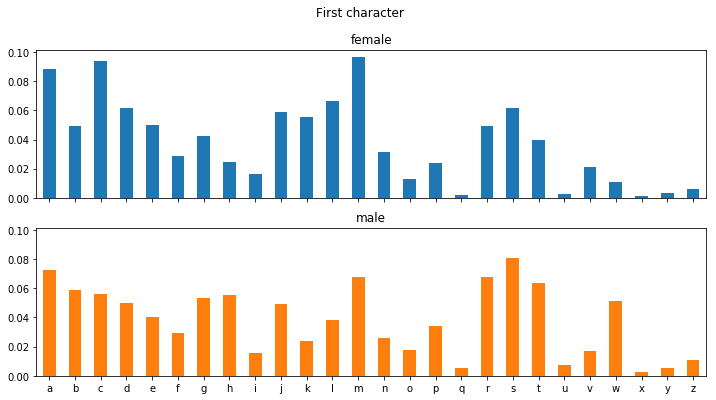

In [3]:
# calculate percentage of names starting with character by gender
# TODO Change Y-axis to percenage, change plot to custom function
dfCrsFstChr = \
pd.crosstab(index=dfNames['firstChar'], 
                     columns=dfNames['gender'], 
                     values=1, 
                     aggfunc='sum', 
                     normalize='columns')# .applymap('{:.2f}%'.format)

# bar plot of first character against gender
pltCrs = \
dfCrsFstChr.plot(kind = 'bar', subplots = True, stacked = False
                 , rot = 0, figsize=(12,6), legend=False
                 , sharey = True, title = 'First character')

plt.xlabel('')
plt.show()

Reviewing the proportion of names ending with a given letter we see that a large proportion of female names end in the letters a and e both of which occur at a considerably higher rate for females than males.  Expanding to all vowels we see the trend continues for for i, but males have a higher proportion for o and y in this data set.

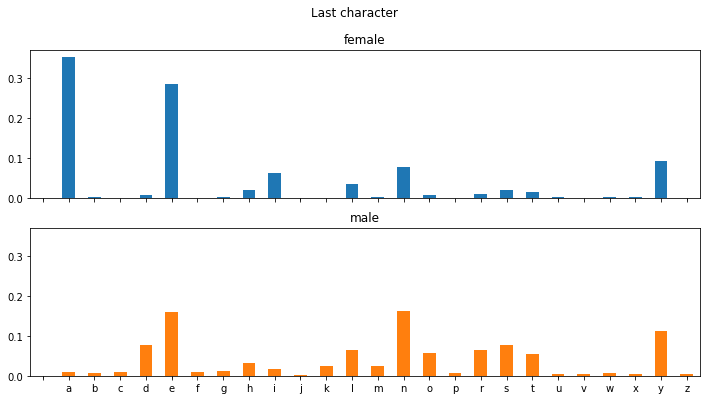

In [4]:
# calculate percentage of names ending with character by gender
dfCrsLstChr = \
pd.crosstab(index=dfNames['lastChar'], 
                     columns=dfNames['gender'], 
                     values=1, 
                     aggfunc='sum', 
                     normalize='columns')# .applymap('{:.2f}%'.format)

# bar plot of first character against gender
pltCrs = \
dfCrsLstChr.plot(kind = 'bar', subplots = True, stacked = False
                 , rot = 0, figsize=(12,6), legend=False
                 , sharey = True, title = 'Last character')

plt.xlabel('')
plt.show()

Exploring the proportion of names containing a particular letter we see that over 50% of female names in the data contain the letter a.

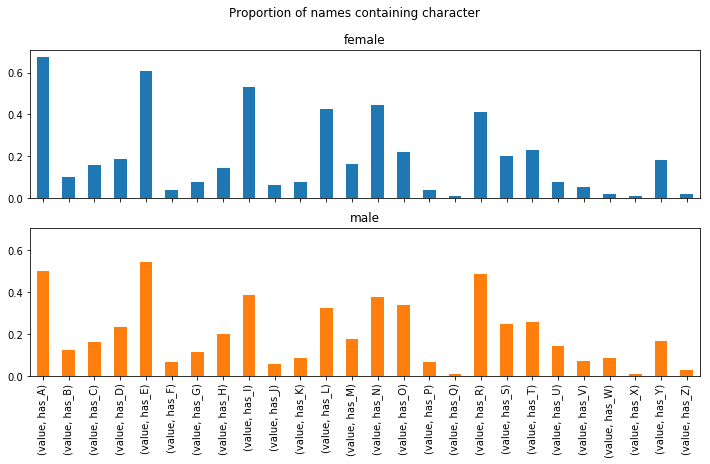

In [5]:
# calculate number of names which have a given letter
dfCrsChrHas = \
dfNames.loc[:, dfNames.columns.to_series().str.match('^has|gender')]\
.melt(id_vars=['gender']).groupby(['gender', 'variable']).sum()\
.unstack().T

# change counts to proportion of names by gender
dfCrsChrHas['female'] = \
dfCrsChrHas['female'] / sum(dfNames['gender'] == 'female')

dfCrsChrHas['male'] = \
dfCrsChrHas['male'] / sum(dfNames['gender'] == 'male')

dfCrsChrHas.plot(kind = 'bar', subplots = True, stacked = False
                 , rot = 90, figsize=(12,6), legend=False
                 , sharey = True, title = 'Proportion of names containing character')


plt.xlabel('')
plt.show()

Looking at the length of names by gender shows a similar distribution for both females and males and is likely not going to provide much information value for classification. Creating a similar visualization (not shown) for number of unique characters, count of consonants, count of vowels, and syllables  produce similar results.

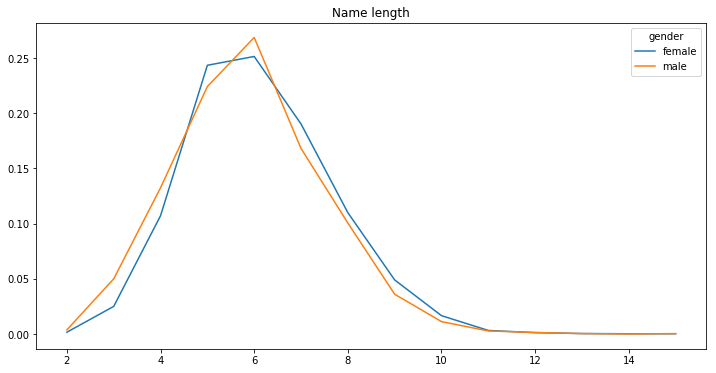

In [6]:
# calculate percentage of name length by gender
dfCrsChrLen = \
pd.crosstab(index=dfNames['cntChar'], columns=dfNames['gender'], 
                     values=1, aggfunc='sum', normalize='columns')

# bar plot of first character against gender
pltCrs = \
dfCrsChrLen.plot(kind = 'line', subplots = False, stacked = False
                 , rot = 0, figsize=(12,6), legend=True
                 , sharey = True, title = 'Name length')

plt.xlabel('')
plt.show()

Comparing the frequency of a name starting or ending with a vowel we see that the number of names starting with vowels vs. consonants are relatively equal by gender, while the number of names ending with a vowel heavily favors names typically associated with females.

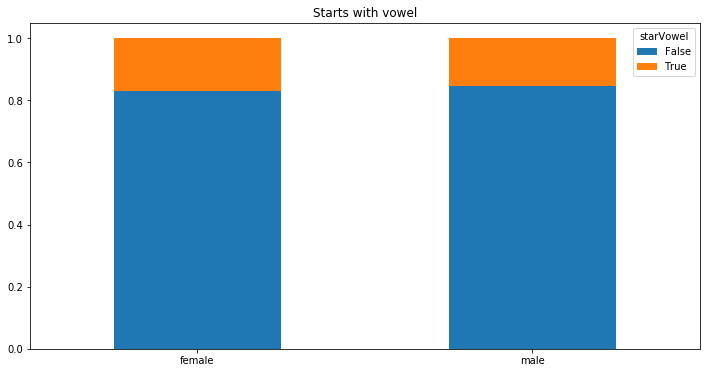

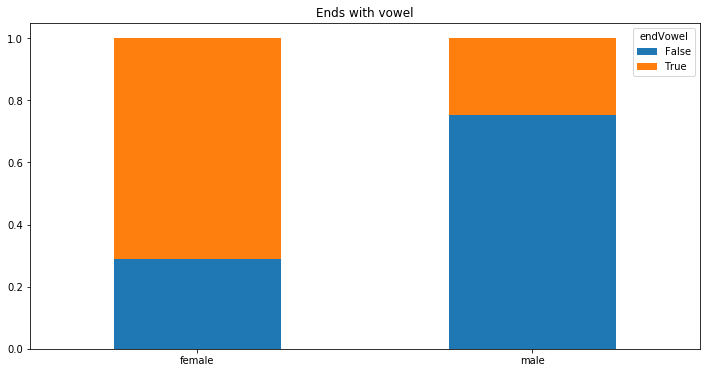

In [7]:
# calculate percentage of names starting with character by gender
dfCrsStrtVwl = \
pd.crosstab(index=dfNames['gender'], columns=dfNames['starVowel'], 
                     values=1, aggfunc='sum', normalize='index')

# bar plot of first character against gender
pltCrs = \
dfCrsStrtVwl.plot(kind = 'bar', subplots = False, stacked = True
                 , rot = 0, figsize=(12,6), legend=True
                 , sharey = True, title = 'Starts with vowel')

plt.xlabel('')
plt.show()

dfCrsEndVwl = \
pd.crosstab(index=dfNames['gender'], columns=dfNames['endVowel'], 
                     values=1, aggfunc='sum', normalize='index')

# bar plot of first character against gender
pltCrs = \
dfCrsEndVwl.plot(kind = 'bar', subplots = False, stacked = True
                 , rot = 0, figsize=(12,6), legend=True
                 , sharey = True, title = 'Ends with vowel')

plt.xlabel('')
plt.show()

## Model development

### Split data

Split the data into three groups, training, development, and testing.

In [8]:
# set random seed for reproducibility
random.seed(20190401)

# randomly sort names list
dfNames = shuffle(dfNames)

# split data into training, development, and testing data sets
dfTest, dfDev, dfTrain = \
dfNames[0:500], dfNames[501:1001], dfNames[1001:]

# print length of data sets
print("Data sizes; Training = {0}, Development = {1}, Testing = {2}"
      .format(len(dfTrain), len(dfDev), len(dfTest)))

Data sizes; Training = 6943, Development = 500, Testing = 500


### Baseline (Naive Bayes)
The baseline model follows the example from Chapter 6 of _Social Network Analysis for Startups_. The model, Naive Bayes Classifier, utilizes the last character and last two characters of each name as features.  The source for the confusion matrix plot function can be found on is from a [StackOverflow question](https://stackoverflow.com/questions/48817300/sklearn-plot-confusion-matrix-combined-across-trainingtest-sets).

Most Informative Features
                  lastBi = 'na'           female : male   =     94.8 : 1.0
                  lastBi = 'la'           female : male   =     66.8 : 1.0
                  lastBi = 'us'             male : female =     38.5 : 1.0
                  lastBi = 'ia'           female : male   =     37.8 : 1.0
                  lastBi = 'sa'           female : male   =     32.9 : 1.0
                lastChar = 'k'              male : female =     32.4 : 1.0
                lastChar = 'a'            female : male   =     30.7 : 1.0
                  lastBi = 'do'             male : female =     25.1 : 1.0
                  lastBi = 'rd'             male : female =     24.7 : 1.0
                  lastBi = 'ta'           female : male   =     23.5 : 1.0
Accuracy = 0.748
Confusion matrix, without normalization


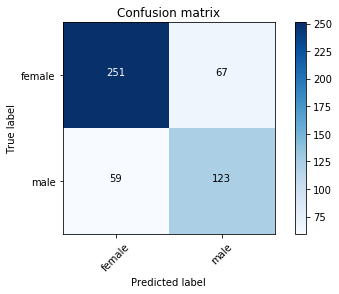

In [9]:
# list of feature columns from dataframe
colFtrNms = ['lastChar', 'lastBi']

# create tuples for train and dev with features as dictionary and gender as classification
tplTrain = \
pd.DataFrame.from_dict(
    {'featues' : dfTrain[list(colFtrNms)].to_dict('records')
     , 'gender' : dfTrain['gender']}).apply(tuple, axis = 1).values.tolist()

tplDev = \
pd.DataFrame.from_dict(
    {'featues' : dfDev[list(colFtrNms)].to_dict('records')
     , 'gender' : dfDev['gender']}).apply(tuple, axis = 1).values.tolist()

# train classifier
bslnMdlTrain = nltk.NaiveBayesClassifier.train(tplTrain)

# show most informative
bslnMdlTrain.show_most_informative_features(10)

# check accuracy on dev data
print("Accuracy = {0}".format(nltk.classify.accuracy(bslnMdlTrain, tplDev)))

# classify dev data
devPred = []
for row in dfDev[list(colFtrNms)].to_dict('records'):
        devPred.append(bslnMdlTrain.classify(row))


# confusion matrix
# print(nltk.ConfusionMatrix(dfDev['gender'].tolist(), devPred))
bslnDevCM = confusion_matrix(dfDev['gender'].tolist(), devPred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# cm = confusion_matrix(y_true, y_pred)
# np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(bslnDevCM, classes=['female', 'male'],
                      title='Confusion matrix', normalize=False)


### Class developed model

#### Naive Bayes

Building on what was done in the textbook example this model incudes; first letter, last letter, first trigram, last trigram, and three features indicating whether the name has consonant clusters.


Most Informative Features
                lastChar = 'k'              male : female =     32.4 : 1.0
                lastChar = 'a'            female : male   =     30.7 : 1.0
                 lastTri = 'ana'          female : male   =     24.5 : 1.0
                 lastTri = 'tta'          female : male   =     23.7 : 1.0
                 lastTri = 'ard'            male : female =     20.3 : 1.0
                 lastTri = 'nne'          female : male   =     18.8 : 1.0
                 lastTri = 'old'            male : female =     17.2 : 1.0
                 lastTri = 'son'            male : female =     15.4 : 1.0
                 lastTri = 'ita'          female : male   =     15.2 : 1.0
                lastChar = 'f'              male : female =     14.6 : 1.0
Accuracy = 0.83
Confusion matrix, without normalization


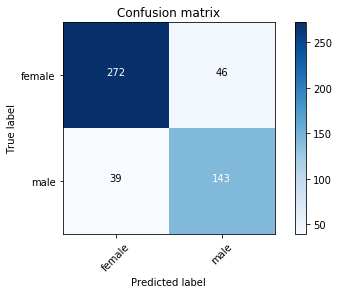

In [11]:
# list of feature columns from dataframe
colFtrNms = ['firstChar', 'lastChar', 'firstTri', 'lastTri'\
             , 'cntSyll',  'clusters1', 'clusters2', 'clusters3']

# create tuples for train and dev with features as dictionary and gender as classification
tplTrain = \
pd.DataFrame.from_dict(
    {'featues' : dfTrain[list(colFtrNms)].to_dict('records')
     , 'gender' : dfTrain['gender']}).apply(tuple, axis = 1).values.tolist()

tplDev = \
pd.DataFrame.from_dict(
    {'featues' : dfDev[list(colFtrNms)].to_dict('records')
     , 'gender' : dfDev['gender']}).apply(tuple, axis = 1).values.tolist()

# train classifier
nbMdlTrain = nltk.NaiveBayesClassifier.train(tplTrain)

# show most informative
nbMdlTrain.show_most_informative_features(10)

# check accuracy on dev data
print("Accuracy = {0}".format(nltk.classify.accuracy(nbMdlTrain, tplDev)))

# classify dev data
devPred = []
for row in dfDev[list(colFtrNms)].to_dict('records'):
        devPred.append(nbMdlTrain.classify(row))


# confusion matrix
# print(nltk.ConfusionMatrix(dfDev['gender'].tolist(), devPred))
bslnDevCM = confusion_matrix(dfDev['gender'].tolist(), devPred)

plt.figure()
plot_confusion_matrix(bslnDevCM, classes=['female', 'male'],
                      title='Confusion matrix', normalize=False)


#### Decision tree

__NLTK decision tree__

Accuracy = 0.716
Confusion matrix, without normalization


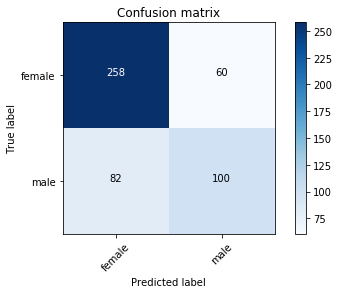

In [12]:
# Repeat best naive bayes model using decision tree
# list of feature columns from dataframe
colFtrNms = ['firstChar', 'lastChar', 'firstTri', 'lastTri'\
             , 'cntSyll', 'clusters1', 'clusters2', 'clusters3']

# create tuples for train and dev with features as dictionary and gender as classification
tplTrain = \
pd.DataFrame.from_dict(
    {'featues' : dfTrain[list(colFtrNms)].to_dict('records')
     , 'gender' : dfTrain['gender']}).apply(tuple, axis = 1).values.tolist()

tplDev = \
pd.DataFrame.from_dict(
    {'featues' : dfDev[list(colFtrNms)].to_dict('records')
     , 'gender' : dfDev['gender']}).apply(tuple, axis = 1).values.tolist()

# train classifier
dtMdlTrain = nltk.DecisionTreeClassifier.train(tplTrain, entropy_cutoff=0,support_cutoff=0)

# check accuracy on dev data
print("Accuracy = {0}".format(nltk.classify.accuracy(dtMdlTrain, tplDev)))

# classify dev data
devPred = []
for row in dfDev[list(colFtrNms)].to_dict('records'):
        devPred.append(dtMdlTrain.classify(row))


# confusion matrix
# print(nltk.ConfusionMatrix(dfDev['gender'].tolist(), devPred))
bslnDevCM = confusion_matrix(dfDev['gender'].tolist(), devPred)

plt.figure()
plot_confusion_matrix(bslnDevCM, classes=['female', 'male'],
                      title='Confusion matrix', normalize=False)


__Sklearn decision tree__

In [ ]:
from sklearn import preprocessing

def clean_cat_data(tplTrain, columns):
  le = preprocessing.LabelEncoder()

  features = [i[0] for i in tplTrain]
  genders = [i[1] for i in tplTrain]
  feat_df = pd.DataFrame.from_dict(features)
  
  for col in columns:
    le.fit(feat_df[col])
    feat_df[col] = le.transform(feat_df[col])
    
  sample_feats = feat_df[columns]
  
  return sample_feats, genders

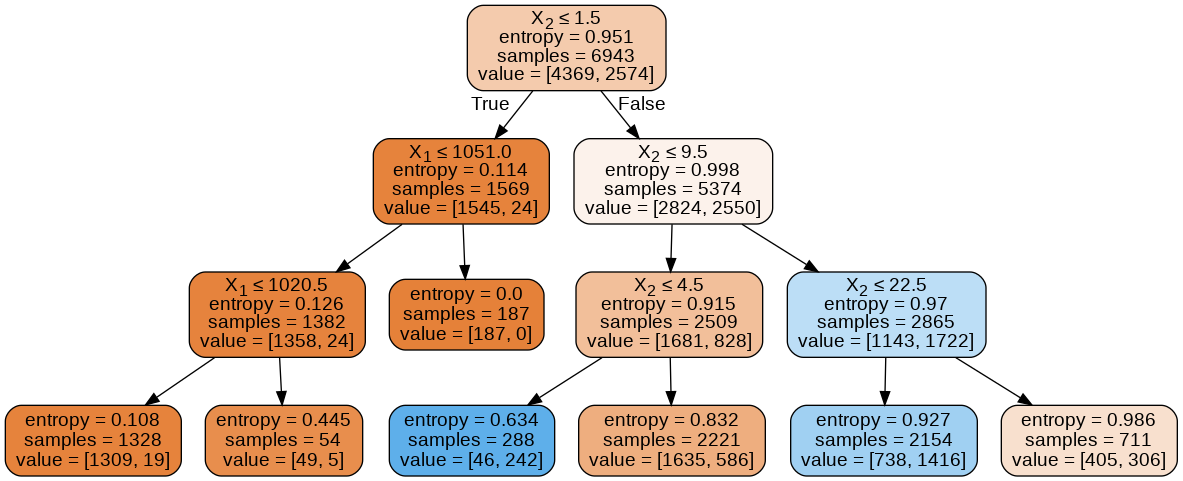

In [ ]:
from sklearn.tree import DecisionTreeClassifier

sample_feats, genders = clean_cat_data(tplTrain, ['firstChar','firstTri','lastChar','lastTri'])

dtree=DecisionTreeClassifier(criterion="entropy", max_depth=3)
dtree.fit(sample_feats,genders)

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
from sklearn import metrics
test_feats, test_genders = clean_cat_data(tplDev, ['firstChar','firstTri','lastChar','lastTri'])

y_pred = dtree.predict(test_feats)
print("Accuracy:",metrics.accuracy_score(test_genders, y_pred))

Accuracy: 0.646


### Simple Neural Network
 
 Using the Multi-Layer Perceptron (MLP) algorithm from the sklearn package, we can test to see if a neural network will give us better results. Before this function can be used, the data will need to be prepped further.  All categorical variables will need to be mapped to a numerical value.
 

In [ ]:
#Remove name column since the features and characteristic of the names have already been calculated.
dfTrim = dfNames.drop(['name'], axis=1)

#Map male and female variables to 0 and 1 respectively
dfTrim = dfTrim.replace({'gender': {'male': 0, 'female': 1}})

#Change all categorical variables to binary-numerical variables (1 or 0)
#Logical True/False variables don't apply here
dfTrim = pd.get_dummies(dfTrim)

#For the columns that are boolean only, multiply the entire dataframe by 1.
#This will change True to 1 and False to 0. Other values will stay the same
dfTrim = dfTrim*1
 
#Include most important features based on the Naive Bayes baseline model
#since the MLPClassifier function doesn't have native feature selection/filtering.
dfTrim2 = dfTrim[['gender', 'lastBi_na','lastBi_la','lastBi_ia','lastBi_ta','lastChar_k',
                  'lastChar_a', 'lastBi_sa', 'lastBi_rt', 'lastBi_us', 'lastBi_ra']]

In [ ]:
#Split data
#This dataframe uses all columns
X = dfTrim.drop('gender', axis=1)
y = dfTrim['gender']

#This dataframe uses only the important columns classified in the previous 
#Naive Bayes approach
X2 = dfTrim2.drop('gender', axis=1)
y2 = dfTrim2['gender']

#Using the built-in functions to split the data. 
#Dev-test will be created manually if results are promising
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2)

In [8]:
#According to sklearn, Multi-Layer Perceptron is sensitive to feature scaling,
#so they recommend normalizing the data
scaler = StandardScaler()

#Fit to training data
scaler.fit(X_train)

#Normalize the dataframes
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Example of the data normalized
print(X_train[1:10])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  import sys


[[ 1.88804477  1.34388209  2.12085789 ... -0.01832473 -0.01295646
  -0.01295646]
 [-0.65697123 -0.90039974 -0.47470623 ... -0.01832473 -0.01295646
  -0.01295646]
 [ 1.25179077  1.34388209  1.25566985 ... -0.01832473 -0.01295646
  -0.01295646]
 ...
 [-1.92947923 -1.64849369 -2.2050823  ... -0.01832473 -0.01295646
  -0.01295646]
 [ 0.61553677 -0.1523058   1.25566985 ... -0.01832473 -0.01295646
  -0.01295646]
 [ 0.61553677 -0.1523058   0.39048181 ... -0.01832473 -0.01295646
  -0.01295646]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  


**Training the model**

Depending on the hyper-parameters that are chosen, this may take a long time to compute.  The hidden layer is the amount of neurons that are in between the input and output layers. The output layer will be either a 1 or 0.  The hidden_layer paraemeter is a tuple that signifies how many layers there are and how many are in each layer.  Max_iter is how many times the classifier runs through the data and the alpha parameter signifies how much the errors are 'punished' for.  Small number means the weights are adjusted slightly where a larger number adjusts the weights more.  Changing these values can increase or decrease the accuracy as well as the computational time.

In [14]:
#Train the full feature model

#All features
#mlp = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, random_state=1, alpha=.0001) #78% precision
mlp = MLPClassifier(hidden_layer_sizes=(500,500,500), max_iter=500, random_state=1, alpha=.0001) #80% precision
#mlp = MLPClassifier(hidden_layer_sizes=(250,250,250), max_iter=5000, random_state=1, alpha=.0001) #80% precision

#Fitting the model and printing results
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[ 529  188]
 [ 213 1056]]
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       717
           1       0.85      0.83      0.84      1269

   micro avg       0.80      0.80      0.80      1986
   macro avg       0.78      0.78      0.78      1986
weighted avg       0.80      0.80      0.80      1986



In [13]:
#Train the selective feature model.

scaler2 = StandardScaler()
scaler2.fit(X_train2)

X_train2 = scaler2.transform(X_train2)
X_test2 = scaler2.transform(X_test2)

#Selective features
mlp2 = MLPClassifier(hidden_layer_sizes=(15,15,15), max_iter=500, random_state=1, alpha=.0001) #65% precision
#mlp = MLPClassifier(hidden_layer_sizes=(150,150,150), max_iter=5000, random_state=1, alpha=.01) #65% precision

#Fitting the model and printing results
mlp2.fit(X_train2, y_train2)

predictions2 = mlp2.predict(X_test2)

print(confusion_matrix(y_test2,predictions2))
print(classification_report(y_test2,predictions2))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  


[[  41  706]
 [   1 1238]]
              precision    recall  f1-score   support

           0       0.98      0.05      0.10       747
           1       0.64      1.00      0.78      1239

   micro avg       0.64      0.64      0.64      1986
   macro avg       0.81      0.53      0.44      1986
weighted avg       0.76      0.64      0.52      1986



**Neural Network Summary**

There are some interesting circumstances when the model is run on the different datasets.  The model for the full dataset has the most precision at around 80%.  This still isn't as good as the Naive Bayes model.  The model with the limited columns has an even worse precision rate at 76%.  The interesting thing is that this model can predict male names better than the full feature model, a comparison of 98% to 71%.  This can be attributed to what columns were selected for this model as well as what hyper-parameters are selected.  A more advanced neural network or better tuning for this model may produce better results.

## Team3

In [14]:
dfNames.head(5)

,name,gender,firstChar,firstBi,firstTri,lastChar,lastBi,lastTri,cntChar,cntUnqChar,...,cnt_X,has_X,cnt_Y,has_Y,cnt_Z,has_Z,cntSyll,clusters1,clusters2,clusters3
5177,arthur,male,a,ar,art,r,ur,hur,6,5,...,0,False,0,False,0,False,2,th,None,None
4642,teressa,female,t,te,ter,a,sa,ssa,7,5,...,0,False,0,False,0,False,3,None,None,None
4106,rheta,female,r,rh,rhe,a,ta,eta,5,5,...,0,False,0,False,0,False,2,None,None,None
3672,nady,female,n,na,nad,y,dy,ady,4,4,...,0,False,1,True,0,False,2,None,None,None
2793,kissie,female,k,ki,kis,e,ie,sie,6,4,...,0,False,0,False,0,False,1,None,None,None


In [15]:
All_Names=pd.DataFrame(dfNames)

# Create a set of dummy variables from the sex variable
df_sex= pd.get_dummies(All_Names['gender'])

In [16]:
#create numerica column for gender
All_Names= pd.concat([All_Names, df_sex], axis=1)
All_Names.columns

Index(['name', 'gender', 'firstChar', 'firstBi', 'firstTri', 'lastChar',
       'lastBi', 'lastTri', 'cntChar', 'cntUnqChar', 'cntConsns', 'cntVowels',
       'starVowel', 'endVowel', 'cnt_A', 'has_A', 'cnt_B', 'has_B', 'cnt_C',
       'has_C', 'cnt_D', 'has_D', 'cnt_E', 'has_E', 'cnt_F', 'has_F', 'cnt_G',
       'has_G', 'cnt_H', 'has_H', 'cnt_I', 'has_I', 'cnt_J', 'has_J', 'cnt_K',
       'has_K', 'cnt_L', 'has_L', 'cnt_M', 'has_M', 'cnt_N', 'has_N', 'cnt_O',
       'has_O', 'cnt_P', 'has_P', 'cnt_Q', 'has_Q', 'cnt_R', 'has_R', 'cnt_S',
       'has_S', 'cnt_T', 'has_T', 'cnt_U', 'has_U', 'cnt_V', 'has_V', 'cnt_W',
       'has_W', 'cnt_X', 'has_X', 'cnt_Y', 'has_Y', 'cnt_Z', 'has_Z',
       'cntSyll', 'clusters1', 'clusters2', 'clusters3', 'female', 'male'],
      dtype='object')

In [17]:
#femal=1, male=0
All_Names['gender_num'] = np.where(All_Names.female == 1, 1,0)
All_Names=All_Names.drop(['female', 'male'],axis=1)

In [18]:
#select all numerical columns 
numerics=['int16','int32','int64','float32','float64']
All_Names_num=All_Names.select_dtypes(include=numerics)
All_Names_num.columns

Index(['cntChar', 'cntUnqChar', 'cntConsns', 'cntVowels', 'cnt_A', 'cnt_B',
       'cnt_C', 'cnt_D', 'cnt_E', 'cnt_F', 'cnt_G', 'cnt_H', 'cnt_I', 'cnt_J',
       'cnt_K', 'cnt_L', 'cnt_M', 'cnt_N', 'cnt_O', 'cnt_P', 'cnt_Q', 'cnt_R',
       'cnt_S', 'cnt_T', 'cnt_U', 'cnt_V', 'cnt_W', 'cnt_X', 'cnt_Y', 'cnt_Z',
       'cntSyll', 'gender_num'],
      dtype='object')

In [19]:
All_Names_num.head(10)

,cntChar,cntUnqChar,cntConsns,cntVowels,cnt_A,cnt_B,cnt_C,cnt_D,cnt_E,cnt_F,...,cnt_S,cnt_T,cnt_U,cnt_V,cnt_W,cnt_X,cnt_Y,cnt_Z,cntSyll,gender_num
5177,6,5,4,2,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,2,0
4642,7,5,4,3,1,0,0,0,2,0,...,2,1,0,0,0,0,0,0,3,1
4106,5,5,3,2,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,2,1
3672,4,4,3,1,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,2,1
2793,6,4,3,3,0,0,0,0,1,0,...,2,0,0,0,0,0,0,0,1,1
6243,7,7,4,3,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3,0
7469,6,6,4,2,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,2,0
6401,6,6,4,2,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,2,0
1799,5,5,3,2,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2,1
108,10,7,6,4,3,0,0,1,1,0,...,2,0,0,0,0,0,0,0,4,1


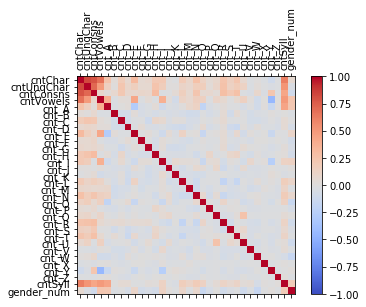

In [20]:
corr = All_Names_num.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(All_Names_num.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(All_Names_num.columns)
ax.set_yticklabels(All_Names_num.columns)
plt.show()

In [21]:
score_corr=All_Names_num.corr(method ='pearson') 
score_corr=score_corr.sort_values(by=['gender_num'])
score_corr.gender_num.head(10)

cnt_W       -0.155416
cnt_O       -0.147454
cnt_U       -0.103902
cntConsns   -0.101230
cnt_R       -0.089465
cnt_H       -0.074913
cnt_F       -0.070527
cnt_D       -0.060332
cnt_P       -0.056047
cnt_G       -0.053793
Name: gender_num, dtype: float64

In [22]:
score_corr.gender_num.tail(10)

cnt_Y         0.022398
cntChar       0.067322
cnt_N         0.082118
cnt_L         0.101569
cnt_E         0.105287
cnt_I         0.138905
cntSyll       0.183163
cnt_A         0.219535
cntVowels     0.232340
gender_num    1.000000
Name: gender_num, dtype: float64

In [23]:
corr_columns=['cnt_W','cnt_O','cnt_U','cntConsns'  ,'cnt_L' ,'cnt_E','cnt_I','cntSyll','cnt_A','cntVowels']

In [24]:
# set random seed for reproducibility
random.seed(20190401)

# randomly sort names list
All_Names_num = shuffle(All_Names_num)

# split data into training, development, and testing data sets
dfTest, dfTrain = \
All_Names_num[0:500], All_Names_num[500:]

# print length of data sets
print("Data sizes; Training = {0}, Testing = {1}"
      .format(len(dfTrain), len(dfTest)))

Data sizes; Training = 7444, Testing = 500


In [25]:


#import model classifer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import numpy as np

#Use K fold and cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score



In [26]:
#Create a copy of train survival column for comparison    
train_data = dfTrain.drop('gender_num',axis=1)
target = dfTrain['gender_num']
    

In [27]:
from sklearn.model_selection import KFold

In [31]:
### MODELLING

print("Determining the best models with given data...\n")

# cross validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)


names = ["Nearest Neighbors","Linear SVM","RBF SVM","Decision Tree", "Random Forest", "AdaBoost"]


classifiers = [
    KNeighborsClassifier(13),
    SVC(kernel="linear", C=0.025),
    SVC(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=13, max_features=1),
    AdaBoostClassifier()]



classifier_scores = {}


for name, clf in zip(names, classifiers):
    clf.fit(train_data, target)
    scoring = 'accuracy'
    score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
    classifier_scores[name] = round(np.mean(score)*100,2)
    
print(classifier_scores)

#pick the best models basic on scores
print("\nThe best classifier is...\n")
best_classifier = max(classifier_scores.keys(), key=(lambda k: classifier_scores[k]))
print(best_classifier)
print("\n")


print("Saving classifier score...\n")
score_pd = pd.DataFrame.from_dict(classifier_scores, orient='index')


#train with the best model!!!!!
print("\nTraining the model...\n")

clf = classifiers[names.index(best_classifier)]
clf.fit(train_data, target)


Determining the best models with given data...



C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

{'Nearest Neighbors': 73.78, 'Linear SVM': 73.09, 'RBF SVM': 74.99, 'Decision Tree': 71.84, 'Random Forest': 63.97, 'AdaBoost': 72.74}

The best classifier is...

RBF SVM


Saving classifier score...


Training the model...



C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [32]:
#prepare for test data
test_data = dfTest.drop('gender_num',axis=1)
target = dfTest['gender_num'] 

In [34]:
prediction = clf.predict(test_data)  

In [35]:
#Format the prediction result
comparision = pd.DataFrame ( {
 "Target": target,
 "Prediction": prediction
 } )

In [39]:
comparision['match'] = np.where( (comparision.Target+comparision.Prediction) == 1, False, True)

In [44]:
len(comparision[comparision.match == True])/len(comparision)

0.748

In [37]:
from sklearn.metrics import confusion_matrix
from show_confusion_matrix import show_confusion_matrix
confusion_matrix(target, prediction)


array([[ 98,  85],
       [ 41, 276]], dtype=int64)

### Selected model

For selecting a model the decided goal was to optimize based on accuracy. Of the models produced the Naive Bayes model using; first character, last character, first trigram, last trigram, syllable count, and consonant clusters had the highest accuracy.  

## Final evaluation

How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect? The accuracy of test and training set are very close. The model performs similarly on the dev-test and test set. We can say that the model is a good fitted model.

In [13]:
# test accuracy of selected model on reserved test data
tplTest = \
pd.DataFrame.from_dict(
    {'featues' : dfTest[list(colFtrNms)].to_dict('records')
     , 'gender' : dfTest['gender']}).apply(tuple, axis = 1).values.tolist()

print("Accuracy = {0}".format(nltk.classify.accuracy(nbMdlTrain, tplTest)))

Accuracy = 0.834
